In [ ]:
# Install necessary dependencies (Run this only once)
!pip install --upgrade torch torchvision torchaudio bitsandbytes diffusers transformers

In [10]:
import torch
from diffusers import StableDiffusionPipeline

# Check CUDA availability
if torch.cuda.is_available():
    device = "cuda"
    torch_dtype = torch.float16  # GPU efficiency
else:
    device = "cpu"
    torch_dtype = torch.float32  # CPU fallback

# Load Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2",
    torch_dtype=torch_dtype
).to(device)

# Enable memory optimization
if device == "cuda":
    pipe.enable_attention_slicing()



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
# Get user inputs
prompts = {
    "Introduction": input("Enter the Introduction prompt: "),
    "Storyline": input("Enter the Storyline prompt: "),
    "Climax": input("Enter the Climax prompt: "),
    "Model": input("Enter the Model prompt: ")
}

# Generate and display/save images
for section, prompt in prompts.items():
    print(f"Generating image for: {section}...")
    image = pipe(prompt).images[0]
    image.show(title=section)
    image.save(f"{section.lower()}_image.png")

print("✅ All images generated and saved!")

Enter the Introduction prompt: Introduce a curious young robot named Pixi, who lives in a junkyard and dreams of becoming an artist.
Enter the Storyline prompt: One day, Pixi finds a broken paintbrush with magical abilities. Despite having no arms, Pixi invents a painting tool from old wires and gears.
Enter the Climax prompt: During a local art contest, other robots laugh at Pixi. But the magic brush activates and paints a stunning mural that leaves everyone speechless.
Enter the Model prompt: True creativity comes from passion, not perfection. Never be afraid to dream differently.
Generating image for: Introduction...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for: Storyline...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for: Climax...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image for: Model...


  0%|          | 0/50 [00:00<?, ?it/s]

✅ All images generated and saved!


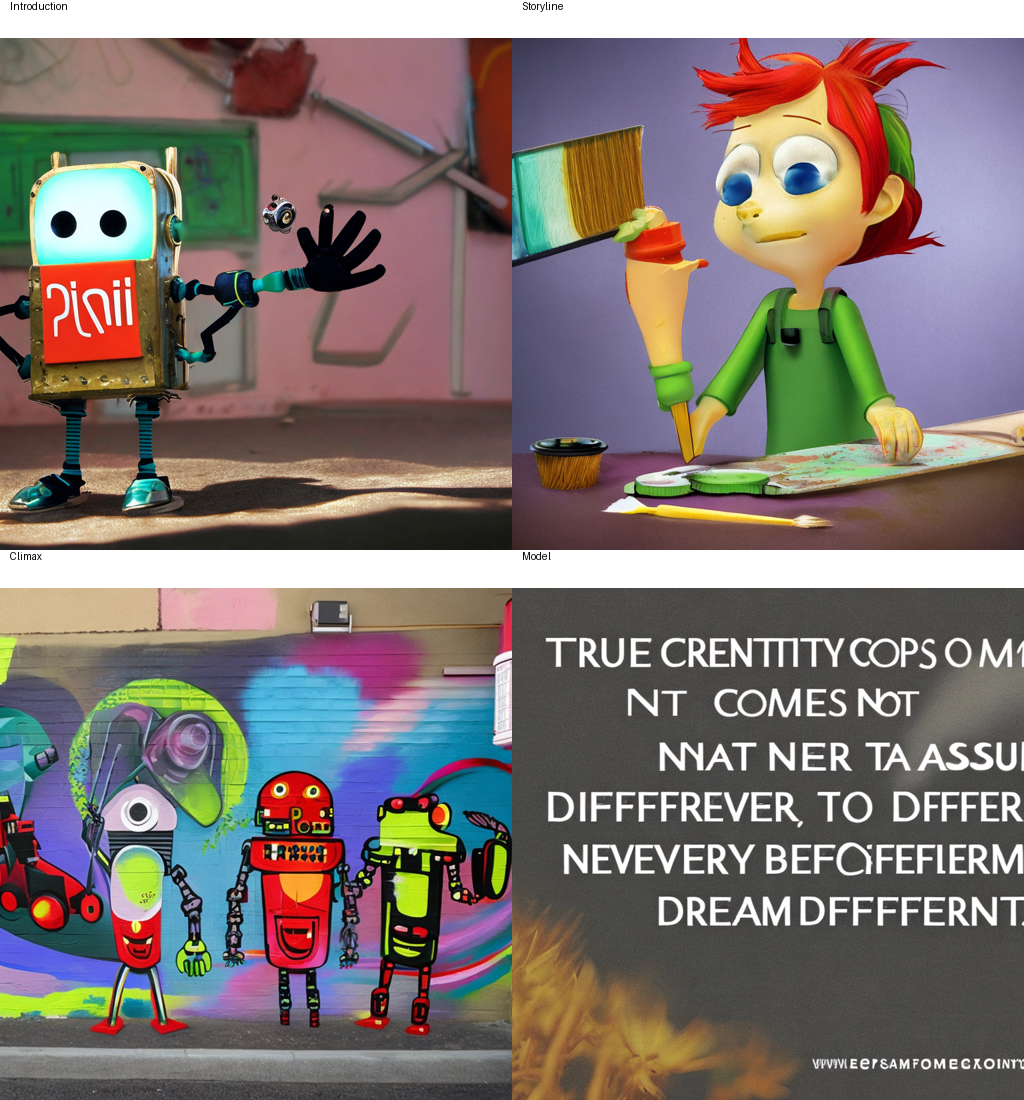

In [12]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

# Define image files and titles
comic_panels = {
    "Introduction": "introduction_image.png",
    "Storyline": "storyline_image.png",
    "Climax": "climax_image.png",
    "Model": "model_image.png"
}

# Optional: load a font (fallback to default if not found)
try:
    font = ImageFont.truetype("arial.ttf", 24)
except:
    font = ImageFont.load_default()

# Load images
images = [Image.open(img_path).resize((512, 512)) for img_path in comic_panels.values()]

# Create a blank canvas (2x2 grid of 512x512 + space for titles)
comic_width = 2 * 512
comic_height = 2 * 550  # 512 image + ~38px for title
comic_page = Image.new("RGB", (comic_width, comic_height), "white")

draw = ImageDraw.Draw(comic_page)

# Paste images and add text
x_offsets = [0, 512]
y_offsets = [0, 550]

for idx, (title, img) in enumerate(zip(comic_panels.keys(), images)):
    x = x_offsets[idx % 2]
    y = y_offsets[idx // 2]

    # Draw title
    draw.text((x + 10, y), title, fill="black", font=font)

    # Paste image
    comic_page.paste(img, (x, y + 38))

# Save the comic layout
comic_page.save("comic_page.png")
comic_page.show()
display(comic_page)

In [13]:
!pip install gradio


In [15]:
import torch
from diffusers import StableDiffusionPipeline
import gradio as gr
from PIL import Image, ImageDraw, ImageFont

# Check CUDA availability
if torch.cuda.is_available():
    device = "cuda"
    torch_dtype = torch.float16  # Use float16 for GPU efficiency
else:
    device = "cpu"
    torch_dtype = torch.float32  # Use float32 for CPU fallback

# Load Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2",
    torch_dtype=torch_dtype
).to(device)

# Enable memory optimization
if device == "cuda":
    pipe.enable_attention_slicing()

# Function to generate image based on input prompt
def generate_image(prompt):
    print(f"Generating image for: {prompt}...")
    image = pipe(prompt).images[0]
    return image

# Function to create the comic page layout with 4 images
def create_comic_page(introduction, storyline, climax, moral):
    # Generate images based on user inputs
    intro_img = generate_image(introduction)
    story_img = generate_image(storyline)
    climax_img = generate_image(climax)
    moral_img = generate_image(moral)

    # Define comic layout
    comic_panels = {
        "Introduction": intro_img,
        "Storyline": story_img,
        "Climax": climax_img,
        "Moral": moral_img
    }

    # Create a blank canvas (2x2 grid for 4 images)
    comic_width, comic_height = 1024, 1100  # Adjusted dimensions
    comic_page = Image.new("RGB", (comic_width, comic_height), "white")
    draw = ImageDraw.Draw(comic_page)

    # Optional: load a font (fallback to default if not found)
    try:
        font = ImageFont.truetype("arial.ttf", 24)
    except:
        font = ImageFont.load_default()

    # X and Y offsets for image placement
    x_offsets = [0, 512]
    y_offsets = [0, 550]

    # Place images and titles
    for idx, (title, img) in enumerate(comic_panels.items()):
        x, y = x_offsets[idx % 2], y_offsets[idx // 2]
        draw.text((x + 10, y), title, fill="black", font=font)  # Draw title
        comic_page.paste(img, (x, y + 38))  # Paste image below title

    return comic_page

# Gradio UI setup
with gr.Blocks() as demo:
    gr.Markdown("# 🎨 AI Comic Crafter")
    gr.Markdown("Enter prompts to generate a **comic page** with AI-generated images!")

    with gr.Row():
        intro_input = gr.Textbox(label="Introduction Prompt", placeholder="Enter Introduction prompt...")
        story_input = gr.Textbox(label="Storyline Prompt", placeholder="Enter Storyline prompt...")

    with gr.Row():
        climax_input = gr.Textbox(label="Climax Prompt", placeholder="Enter Climax prompt...")
        moral_input = gr.Textbox(label="Moral Prompt", placeholder="Enter Moral prompt...")

    generate_btn = gr.Button("Generate Comic")

    gr.Markdown("## Final Comic Layout")
    comic_output = gr.Image(label="Full Comic Page")

    # Button click function to generate comic
    generate_btn.click(create_comic_page,
                       inputs=[intro_input, story_input, climax_input, moral_input],
                       outputs=comic_output)

# Launch the Gradio app
demo.launch(share=True)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3d509d48603a9fb550.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
